# Making a new domain: `CStarSpecBuilder`

This notebook demonstrates how to create a new domain and run a ROMS simulation using C-SON Forge.


## Setup

First, import the necessary modules and define the domain configuration parameters.


In [ ]:
%load_ext autoreload
%autoreload 2

import cson_forge
from datetime import datetime 

grid_name = "test-tiny"
model_name = "cson_roms-marbl_v0.1"
start_time = datetime(2012, 1, 1)
end_time = datetime(2012, 1, 2)

grid_kwargs = dict[str, float](
    nx=6,
    ny=2,
    size_x=500,
    size_y=1000,
    center_lon=0,
    center_lat=55,
    rot=10,
    N=3,  # number of vertical levels
    theta_s=5.0,  # surface control parameter
    theta_b=2.0,  # bottom control parameter
    hc=250.0,  # critical depth
)

boundaries={
        "south": False,
        "east": True,
        "north": True,
        "west": False, 
    }

partitioning = {
    "n_procs_x": 2, # number of partitions in xi (x) 
    "n_procs_y": 1, # number of partitions in eta (y) 
}


## Initialize CstarSpecBuilder

Create a `CstarSpecBuilder` instance with the domain configuration. This initializes the PRECONFIG stage, creating the grid object and blueprint structure.


In [ ]:
ocn = cson_forge.CstarSpecBuilder(
    description="Test tiny",
    model_name=model_name,
    grid_name=grid_name,
    grid_kwargs=grid_kwargs,
    open_boundaries=boundaries,    
    start_time=start_time,
    end_time=end_time,
    partitioning=partitioning,
)


### Visualize the grid

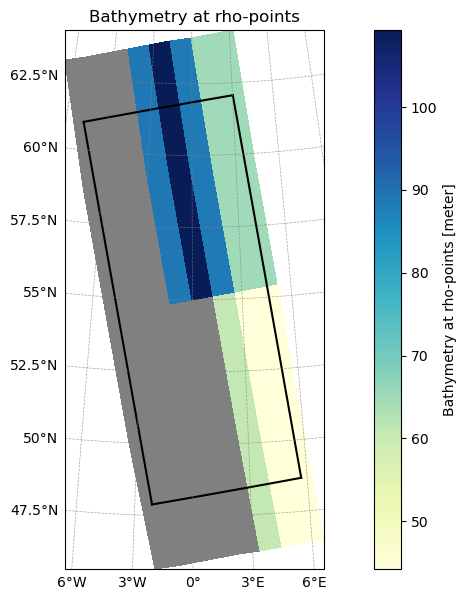

In [ ]:
ocn.grid.plot()

## Prepare Source Data

Ensure that all required source datasets (GLORYS, UNIFIED, SRTM15, etc.) are staged locally. This downloads and prepares the data needed for input generation.


In [ ]:
# ensure that source data is staged locally
ocn.ensure_source_data(clobber=False)


✔️  Using existing GLORYS_REGIONAL file for 2012-01-01: cmems_mod_glo_phy_my_0.083deg_P1D-m_REGIONAL_test-tiny_20120101.nc
✔️  Using existing GLORYS_REGIONAL file for 2012-01-02: cmems_mod_glo_phy_my_0.083deg_P1D-m_REGIONAL_test-tiny_20120102.nc
✔️  TPXO dataset verified at: /Users/mclong/cson-forge-data/source-data/TPXO/TPXO10.v2
✔️  Using existing BGC dataset: /Users/mclong/cson-forge-data/source-data/UNIFIED_BGC/BGCdataset.nc


## Generate Input Files

Generate all model input files (grid, initial conditions, forcing) from the source data. This completes the POSTCONFIG stage and updates the blueprint with actual file paths.

The system will look for an existing blueprint and, if a match is found, it will use that data unless the user sets `clobber=True` to force re-generating the data. 


In [ ]:
# prepare model input
ocn.generate_inputs(clobber=False) # setting clobber=True will overwrite existing files


ℹ️  Using existing blueprint from file: B_cson_roms-marbl_v0.1_test-tiny_postconfig.yml


## Access Generated Input Datasets

Input datasets are available on the `datasets` attribute of the `CstarSpecBuilder` after `generate_inputs()` has completed. The `datasets` dictionary only contains keys for fields that exist in the blueprint and have been successfully generated.

**Note:** Datasets are only available after `generate_inputs()` has run and populated the blueprint with actual file paths. If a key doesn't exist, it means that field wasn't generated or isn't in the blueprint.

In [ ]:
for key in ocn.datasets.keys():
    print("-"*100)
    print(key)
    print(ocn.datasets[key])

----------------------------------------------------------------------------------------------------
grid
<xarray.Dataset> Size: 3kB
Dimensions:    (eta_rho: 4, xi_rho: 8, xi_u: 7, eta_v: 3, s_rho: 3, s_w: 4)
Coordinates:
    lat_rho    (eta_rho, xi_rho) float64 256B ...
    lon_rho    (eta_rho, xi_rho) float64 256B ...
    lat_u      (eta_rho, xi_u) float64 224B ...
    lon_u      (eta_rho, xi_u) float64 224B ...
    lat_v      (eta_v, xi_rho) float64 192B ...
    lon_v      (eta_v, xi_rho) float64 192B ...
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v, s_rho, s_w
Data variables: (12/13)
    angle      (eta_rho, xi_rho) float64 256B ...
    f          (eta_rho, xi_rho) float64 256B ...
    pm         (eta_rho, xi_rho) float64 256B ...
    pn         (eta_rho, xi_rho) float64 256B ...
    spherical  |S1 1B ...
    mask_rho   (eta_rho, xi_rho) int32 128B ...
    ...         ...
    mask_v     (eta_v, xi_rho) int32 96B ...
    h          (eta_rho, xi_rho) float64 256B ...


## Configure Build

Render the Jinja2 templates to generate compile-time and run-time configuration files (`.opt` files, `roms.in`, etc.). This prepares the BUILD stage.


In [ ]:
# configure and build the model
ocn.configure_build(compile_time_settings={}, run_time_settings={})


ROMSSimulation(
name = cson_roms-marbl_v0.1_test-tiny,
directory = /Users/mclong/cson-forge-data/cson-forge-run/cson_roms-marbl_v0.1_test-tiny_20120101-20120102,
start_date = 2012-01-01 00:00:00,
end_date = 2012-01-02 00:00:00,
valid_start_date = 2012-01-01 00:00:00,
valid_end_date = 2012-01-02 00:00:00,
discretization = ROMSDiscretization(time_step = 1800, n_procs_x = 2, n_procs_y = 1),
codebase = <ROMSExternalCodeBase instance>,
runtime_code = <AdditionalCode instance>,
compile_time_code = <AdditionalCode instance>
model_grid = <ROMSModelGrid instance>,
initial_conditions = <ROMSInitialConditions instance>,
tidal_forcing = <ROMSTidalForcing instance>,
river_forcing = <ROMSRiverForcing instance>,
surface_forcing = <list of 2 ROMSSurfaceForcing instances>,
boundary_forcing = <list of 2 ROMSBoundaryForcing instances>,
)

## Build Model Executable

Compile the ROMS/MARBL model source code to create the executable. This uses the C-Star build system to compile the model with the specified configuration.


In [ ]:
ocn.build()


[INFO] 🛠️ Configuring ROMSSimulation
[INFO] 🔧 Setting up ROMSExternalCodeBase...
[INFO] ⚠️  No target_dir provided to ExternalCodeBase.get, defaulting to /Users/mclong/cson-forge-data/codes/C-Star/cstar/externals/ucla-roms
[INFO] 🔧 Setting up MARBLExternalCodeBase...
[INFO] ⚠️  No target_dir provided to ExternalCodeBase.get, defaulting to /Users/mclong/cson-forge-data/codes/C-Star/cstar/externals/MARBL
[INFO] 📦 Fetching compile-time code...
[INFO] 📦 Fetching runtime code... 
[INFO] 📦 Fetching input datasets...


ROMSSimulation(
name = cson_roms-marbl_v0.1_test-tiny,
directory = /Users/mclong/cson-forge-data/cson-forge-run/cson_roms-marbl_v0.1_test-tiny_20120101-20120102,
start_date = 2012-01-01 00:00:00,
end_date = 2012-01-02 00:00:00,
valid_start_date = 2012-01-01 00:00:00,
valid_end_date = 2012-01-02 00:00:00,
discretization = ROMSDiscretization(time_step = 1800, n_procs_x = 2, n_procs_y = 1),
codebase = <ROMSExternalCodeBase instance>,
runtime_code = <AdditionalCode instance>,
compile_time_code = <AdditionalCode instance>
model_grid = <ROMSModelGrid instance>,
initial_conditions = <ROMSInitialConditions instance>,
tidal_forcing = <ROMSTidalForcing instance>,
river_forcing = <ROMSRiverForcing instance>,
surface_forcing = <list of 2 ROMSSurfaceForcing instances>,
boundary_forcing = <list of 2 ROMSBoundaryForcing instances>,
)

## Pre-Run Setup

Perform pre-run operations, including partitioning input files for parallel execution if needed.


In [ ]:
# perform partitioning
ocn.pre_run()


[INFO] Partitioning /Users/mclong/cson-forge-data/cson-forge-run/cson_roms-marbl_v0.1_test-tiny_20120101-20120102/ROMS/input_datasets/cson_roms-marbl_v0.1_grid.nc into (2,1)
[INFO] Partitioning /Users/mclong/cson-forge-data/cson-forge-run/cson_roms-marbl_v0.1_test-tiny_20120101-20120102/ROMS/input_datasets/cson_roms-marbl_v0.1_initial_conditions.nc into (2,1)
[INFO] Partitioning /Users/mclong/cson-forge-data/cson-forge-run/cson_roms-marbl_v0.1_test-tiny_20120101-20120102/ROMS/input_datasets/cson_roms-marbl_v0.1_tidal.nc into (2,1)
[INFO] Partitioning /Users/mclong/cson-forge-data/cson-forge-run/cson_roms-marbl_v0.1_test-tiny_20120101-20120102/ROMS/input_datasets/cson_roms-marbl_v0.1_river.nc into (2,1)
[INFO] Partitioning /Users/mclong/cson-forge-data/cson-forge-run/cson_roms-marbl_v0.1_test-tiny_20120101-20120102/ROMS/input_datasets/cson_roms-marbl_v0.1_boundary-physics_201201.nc into (2,1)
[INFO] Partitioning /Users/mclong/cson-forge-data/cson-forge-run/cson_roms-marbl_v0.1_test-tiny

## Run Model Simulation

Execute the ROMS model simulation. This runs the model with the configured inputs and settings.


In [ ]:
# run the model
ocn.run()


[INFO] Running mpirun -n 2 /Users/mclong/cson-forge-data/cson-forge-run/cson_roms-marbl_v0.1_test-tiny_20120101-20120102/ROMS/compile_time_code/roms /Users/mclong/cson-forge-data/cson-forge-run/cson_roms-marbl_v0.1_test-tiny_20120101-20120102/ROMS/runtime_code/cson_roms-marbl_v0.1_test-tiny.in


LocalProcess(
commands = 'mpirun -n 2 /Users/mclong/cson-forge-data/cson-forge-run/cson_roms-marbl_v0.1_test-tiny_20120101-20120102/ROMS/compile_time_code/roms /Users/mclong/cson-forge-data/cson-forge-run/cson_roms-marbl_v0.1_test-tiny_20120101-20120102/ROMS/runtime_code/cson_roms-marbl_v0.1_test-tiny.in',
output_file = PosixPath('/Users/mclong/cson-forge-data/cson-forge-run/cson_roms-marbl_v0.1_test-tiny_20120101-20120102/output/cstar_process_20260108_144308.out'),
run_path = PosixPath('/Users/mclong/cson-forge-data/cson-forge-run/cson_roms-marbl_v0.1_test-tiny_20120101-20120102/output')
)
State: <status = <ExecutionStatus.RUNNING: 3>>

In [ ]:
ocn.set_blueprint_state(state="draft")